# Track 2: Electricity Usage Prediction
> Guoyin Wang

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

Using TensorFlow backend.


## Section1: Data Preprocessing
- Add holiday
- Seperate weekday, weekend, holiday
- Add high-order temperature term
- Add temperature, humility interaction
- Add last day and rolling previous mean as extra feature
- Make temperture as categorical
- Scale electricity


In [3]:
holiday = ['2015-02-18',
          '2015-02-19',
           '2015-02-20',
           '2015-02-21',
           '2015-02-22',
           '2015-02-23',
           '2015-02-24',
           '2015-04-05',
           '2015-04-06',
           '2015-05-01',
           '2015-06-20',
           '2015-06-22',
           '2015-09-27',
           '2015-10-01',
           '2015-10-02',
           '2015-10-03',
           '2015-10-04',
           '2015-10-05',
           '2015-10-06',
           '2015-10-07',
           '2016-01-01',
           '2016-02-07',
           '2016-02-08',
           '2016-02-09',
           '2016-02-10',
           '2016-02-11',
           '2016-02-12',
           '2016-02-13',
           '2016-04-04',
           '2016-05-01',
           '2016-05-02',
           '2016-06-09',
           '2016-06-10',
           '2016-06-11',
          ]
window = 5
import glob
path =r'data' # use your path
allFiles = glob.glob(path + "/*.csv")

list_ = []
scaler_list = []
for j, file_ in enumerate(allFiles):
    ratio = pd.DataFrame()
    df = pd.read_csv(file_,index_col=None, header=None, names = ['year', 'month','day', 'high', 'low', 'ave', 'hum', 'ele'])
    ratio['ave'] = df['ave'] 
    ratio['high'] = df['high'] 
    ratio['low'] = df['low'] 
    ratio['ele'] = df['ele'] 
    ratio['hum'] = df['hum'] 
    # high order term
    ratio['ave2'] = ratio['ave'] ** 2
    ratio['ave3'] = ratio['ave'] ** 3
    
    # categorical transform
    ratio['ave_int'] = np.floor(ratio['ave']).astype('int')
    ratio['ave2_int'] = np.floor(ratio['ave2']).astype('int')
    ratio['ave3_int'] = np.floor(ratio['ave3']).astype('int')
    
    # interaction
    ratio['ave_hum'] = ratio['ave'] * ratio['hum']
    #scale
    scaler_ele = MinMaxScaler(feature_range=(0, 1))
    ratio['ele_scale'] = scaler_ele.fit_transform(ratio['ele'])
    scaler_list.append(scaler_ele)
    
    # prev
    ratio['ele_prev'] = ratio['ele'].shift(1)
    ratio.loc[0,'ele_prev'] = ratio['ele'][0]
    
    ratio['hum_prev'] = ratio['hum'].shift(1)
    ratio.loc[0,'hum_prev'] = ratio['hum'][0]
    
    ratio['ave_prev'] = ratio['ave'].shift(1)
    ratio.loc[0,'ave_prev'] = ratio['ave'][0]
    
    ratio['ave2_prev'] = ratio['ave2'].shift(1)
    ratio.loc[0,'ave2_prev'] = ratio['ave2'][0]
    
    ratio['ave3_prev'] = ratio['ave3'].shift(1)
    ratio.loc[0,'ave3_prev'] = ratio['ave3'][0]
    
    ratio['ave_hum_prev'] = ratio['ave_hum'].shift(1)
    ratio.loc[0,'ave_hum_prev'] = ratio['ave_hum'][0]
    
    # multi prev 
    ratio['ele_roll'] = pd.rolling_mean(ratio['ele'], window)
    for i in range(window):
        ratio.loc[i,'ele_roll'] = ratio['ele_prev'][i]
        
    ratio['ave_roll'] = pd.rolling_mean(ratio['ave'], window)
    for i in range(window):
        ratio.loc[i,'ave_roll'] = ratio['ave_prev'][i]
    
    ratio['ave2_roll'] = pd.rolling_mean(ratio['ave2'], window)
    for i in range(window):
        ratio.loc[i,'ave2_roll'] = ratio['ave2_prev'][i]
    
    ratio['ave3_roll'] = pd.rolling_mean(ratio['ave3'], window)
    for i in range(window):
        ratio.loc[i,'ave3_roll'] = ratio['ave3_prev'][i]
    
    ratio['hum_roll'] = pd.rolling_mean(ratio['hum'], window)
    for i in range(window):
        ratio.loc[i,'hum_roll'] = ratio['hum_prev'][i]
        
    ratio['ave_hum_roll'] = pd.rolling_mean(ratio['ave_hum'], window)
    for i in range(window):
        ratio.loc[i,'ave_hum_roll'] = ratio['ave_hum_prev'][i]
    
    
    # date
    ratio['date']= pd.to_datetime(df[['year','month','day']], yearfirst=True)
    ratio['weekend'] = (ratio['date'].dt.dayofweek // 5 == 1).astype(float)
    ratio['holiday'] =  ratio['date'].isin(holiday).astype(float)
    ratio['non_workday'] = ratio[['weekend' ,'holiday']].max(axis=1)
    ratio['workday'] = 1 - ratio['non_workday']
    ratio.replace([np.inf, -np.inf], np.nan, inplace=True)
    ratio = ratio.fillna(0.0)
    ratio.drop(['date'], axis=1, inplace=True)
#     ratio.drop(['weekend', 'holiday'], axis=1, inplace=True)
    ratio['group'] = j

        
    list_.append(ratio)


/Users/guoyinwang/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/guoyinwang/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/guoyinwang/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:87: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).

In [4]:
train_full = pd.concat(list_, ignore_index=True)

In [5]:
train_full.head()

,ave,high,low,ele,hum,ave2,ave3,ave_int,ave2_int,ave3_int,...,ave_roll,ave2_roll,ave3_roll,hum_roll,ave_hum_roll,weekend,holiday,non_workday,workday,group
0,0.7875,1.9,-0.4,901.094080,75.000,0.620156,0.488373,0,0,0,...,0.7875,0.620156,0.488373,75.000,59.062500,1.0,0.0,1.0,0.0,0
1,1.7625,6.2,-3.9,744.658412,77.250,3.106406,5.475041,1,3,5,...,0.7875,0.620156,0.488373,75.000,59.062500,0.0,0.0,0.0,1.0,0
2,4.2375,7.8,2.0,743.560438,72.750,17.956406,76.090271,4,17,76,...,1.7625,3.106406,5.475041,77.250,136.153125,0.0,0.0,0.0,1.0,0
3,3.0375,8.5,-1.2,784.915894,65.875,9.226406,28.025209,3,9,28,...,4.2375,17.956406,76.090271,72.750,308.278125,0.0,0.0,0.0,1.0,0
4,1.8625,7.9,-3.6,685.154914,55.375,3.468906,6.460838,1,3,6,...,3.0375,9.226406,28.025209,65.875,200.095313,0.0,0.0,0.0,1.0,0


### Colinearity of high, low, average temperature
The graph below shows that 3 different type of temperature are linearly dependent, so only keep the average temperature as feature should be enough. However, later in the model setup, high and low temperature are still important in the performance.

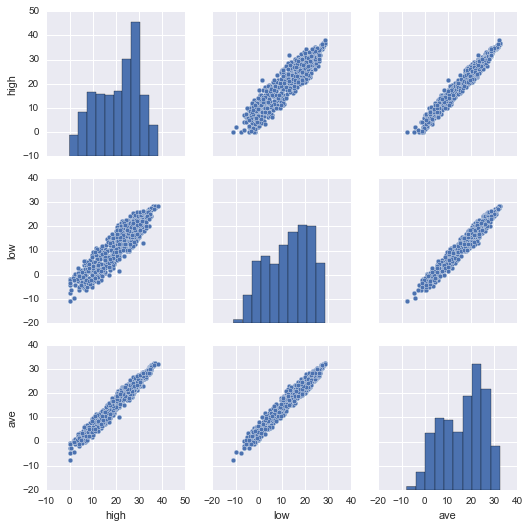

In [6]:
sns.pairplot(train_full[['high','low','ave']])
pass

### High order temperature
electricity is nolinearly depending on temperature, so add nonlinear temperature terms

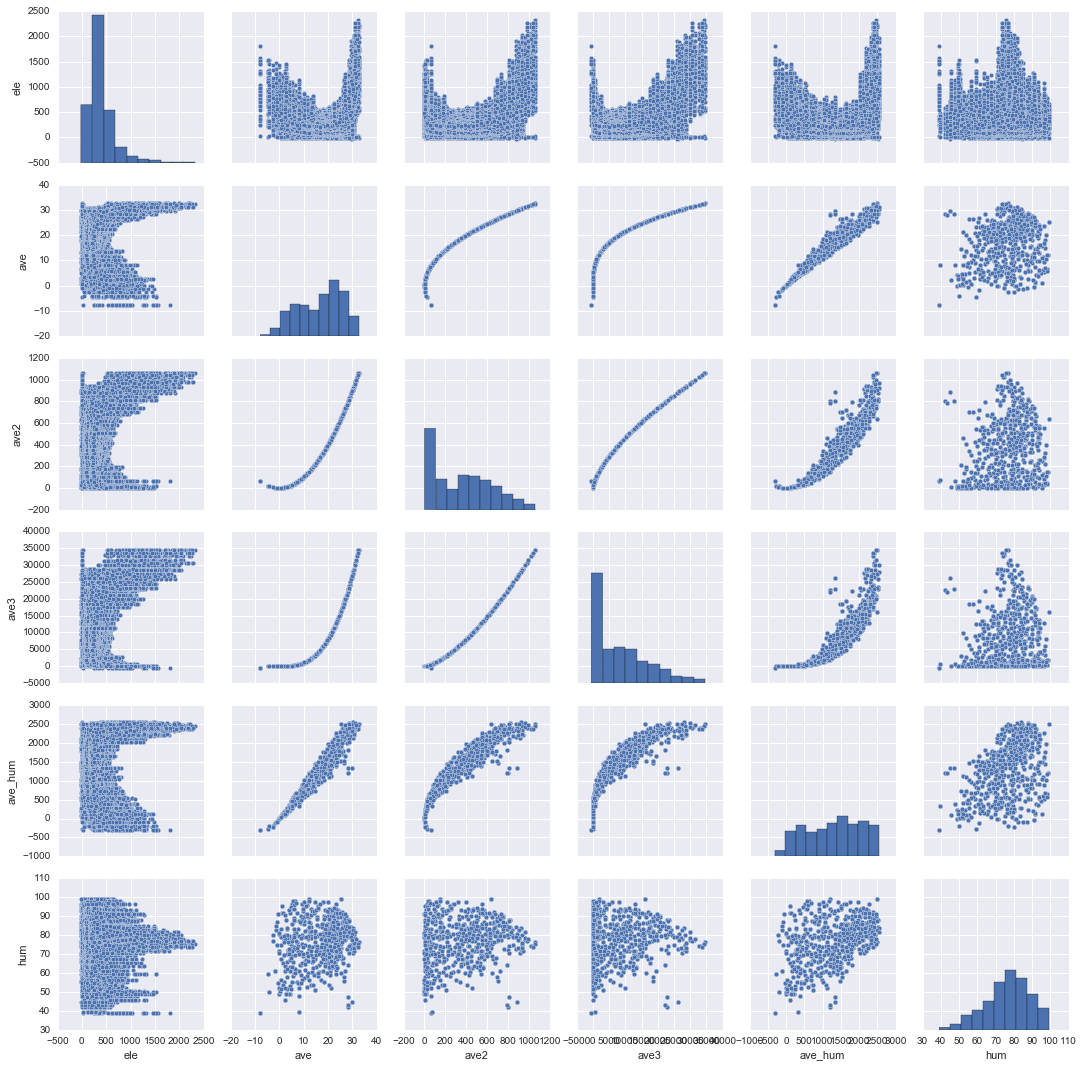

In [7]:
sns.pairplot(train_full[['ele','ave','ave2', 'ave3', 'ave_hum', 'hum']])
pass

### Time dependency
Also add previous day and previous rolling mean data as extra features for time dependency. However, this part is not working in the model.

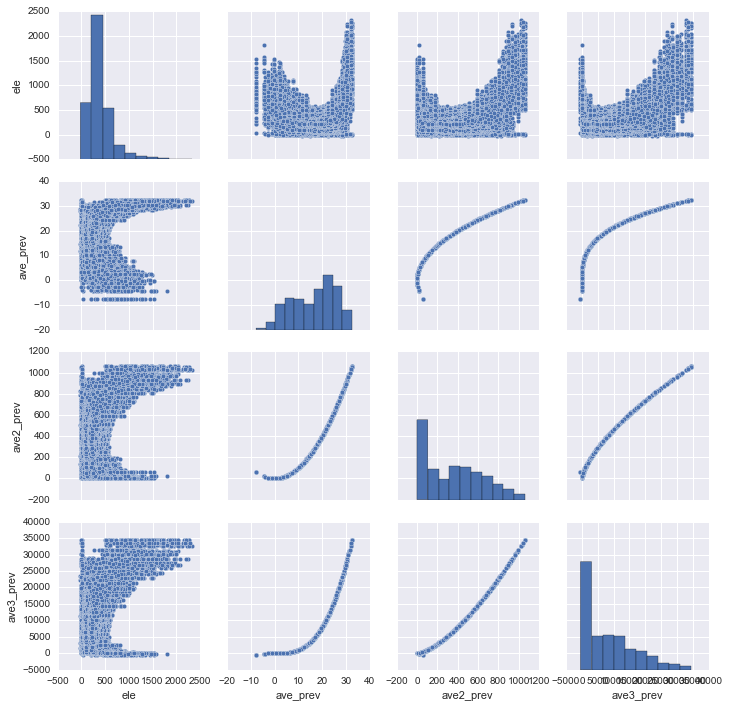

In [8]:
sns.pairplot(train_full[['ele','ave_prev','ave2_prev', 'ave3_prev']])
pass

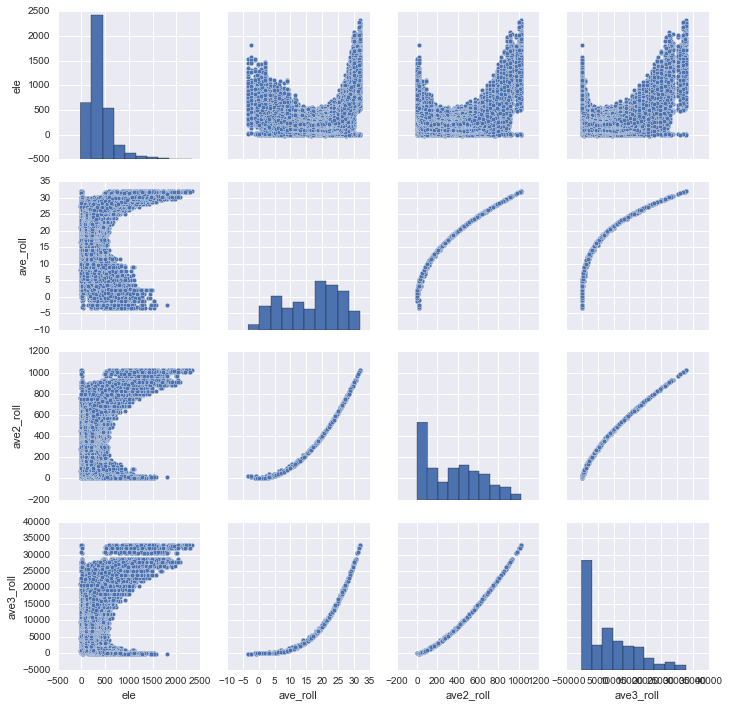

In [9]:
sns.pairplot(train_full[['ele','ave_roll','ave2_roll', 'ave3_roll']])
pass

## Section 2: Model setup
- Using neural network to make the prediction, which needs the prediction to be around 0-1 to have better performance, so we scale the electricity
- Predicting ratio/diff does not work since the error will accumulate, as a result, the final prediction will explose or vanish.
- original feature number is limited, so we do the feature augumentation by adding high order temperature, temperature-humility interaction, categorical temperature, weekday-hoiliday-weekend seperation.
- The sequence to predict is pretty long, so stateful LSTM also not doing well in prediction.
- peak value of temperature greatly effect electricity, so adding gated structure to simulate this effect.
- Limitted number of data points for each station is provided. So use general-seperate structure network to setup the model. The general part will utilize all the data, then seperate part is set to capture the sation-wise specialty. An attention mechanisim is implemented to select the sperate part.



In [10]:
feature_list = ['ave_int', # categorical temperature
                'high','low','ave','hum','ave_hum','ave2','ave3', # same feature
#                 'ave_prev', 'hum_prev', 'ave_hum_prev', 'ave2_prev', 'ave3_prev', # previous day 
#                 'ave_roll', 'hum_roll', 'ave_hum_roll', 'ave2_roll', 'ave3_roll', # rolling mean of previous days
                'holiday','weekend','workday'] # date seperation
x = train_full[feature_list].as_matrix()
y = train_full['ele_scale'].as_matrix()

In [11]:
from mlxtend.preprocessing import one_hot
x_onehot = one_hot(x[:,0].astype('int'))
x = np.concatenate([x_onehot, x[:,1:]], axis=1)

In [12]:
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.15, random_state=42)

In [13]:
num_feature = x.shape[1]

In [14]:
from keras.layers import Dense, Input, LSTM
from keras.models import Model

In [15]:
num_feature

43

### simple model
simple fully connected FNN model

In [16]:
simple_input = Input(shape=(num_feature,), dtype='float32', name='simple_input')

simple_layer0 = Dense(num_feature , activation='relu', name='simple_layer0')(simple_input)
simple_layer1 = Dense(32 , activation='relu', name='simple_layer1')(simple_layer0)
simple_layer2 = Dense(32 , activation='relu', name='simple_layer1')(simple_layer1)
simple_layer3 = Dense(16 , activation='relu', name='simple_layer1')(simple_layer2)
simple_output = Dense(1, activation=None, name='main_predict')(simple_layer1)
simple_model = Model(inputs=simple_input, outputs=simple_output)


In [17]:
simple_model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mape'])

In [18]:
simple_model.fit(x_train, y_train,nb_epoch=50,validation_data=[x_test,y_test])

/Users/guoyinwang/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 22576 samples, validate on 3985 samples
Epoch 1/50
22576/22576 [==============================] - 2s - loss: 230.2542 - mean_absolute_percentage_error: 6895677.4996 - val_loss: 123.0138 - val_mean_absolute_percentage_error: 5302055.0361
Epoch 2/50
22576/22576 [==============================] - 1s - loss: 83.2797 - mean_absolute_percentage_error: 3127010.6925 - val_loss: 1.3149 - val_mean_absolute_percentage_error: 1246079.8446
Epoch 3/50
22576/22576 [==============================] - 1s - loss: 5.9607 - mean_absolute_percentage_error: 1729561.9257 - val_loss: 714.4058 - val_mean_absolute_percentage_error: 17846025.6582
Epoch 4/50
22576/22576 [==============================] - 2s - loss: 67.6879 - mean_absolute_percentage_error: 3661059.2333 - val_loss: 223.3038 - val_mean_absolute_percentage_error: 8753601.7705
Epoch 5/50
22576/22576 [==============================] - 2s - loss: 102.2292 - mean_absolute_percentage_error: 2211574.6609 - val_loss: 0.1435 - val_mean_absolute_perc

In [19]:
y_test_predict = simple_model.predict(x_test)

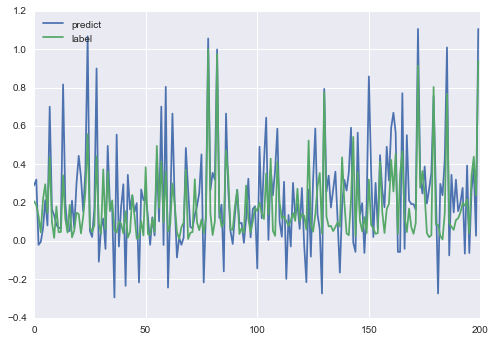

In [20]:
plt.plot(y_test_predict[:200] , label='predict')
plt.plot(y_test[:200] , label='label')
plt.legend(loc='upper left')



### Gated model
model with gated structure

In [21]:
main_input = Input(shape=(num_feature,), dtype='float32', name='main_input')
main_input_bn = keras.layers.normalization.BatchNormalization()(main_input)
# main_input_noise = keras.layers.noise.GaussianNoise(0.0001)(main_input_bn)
main_layer_0 = Dense(num_feature , activation='relu', name='main_layer0')(main_input_bn)
gate_layer_0 = Dense(num_feature , activation='tanh', name='gate_layer0')(main_input)
prod_layer_0 = keras.layers.merge([main_layer_0, gate_layer_0], mode='mul')
main_layer_1 = Dense(num_feature , activation='relu', name='main_layer1')(prod_layer_0)
gate_layer_1 = Dense(num_feature , activation='tanh', name='gate_layer1')(main_input)
prod_layer_1 = keras.layers.merge([main_layer_0, gate_layer_0], mode='mul')

main_layer_2 = Dense(num_feature, activation='relu', name='main_layer2')(prod_layer_1)


main_predict = Dense(1, activation=None, name='main_predict')(main_layer_2)
main_model = Model(input=main_input, output=main_predict)

/Users/guoyinwang/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/guoyinwang/anaconda3/lib/python3.5/site-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/Users/guoyinwang/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/guoyinwang/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ma..., inputs=Tensor("ma...)`


In [22]:
main_model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mape'])

In [23]:
main_model.fit(x_train, y_train,nb_epoch=100,validation_data=[x_test,y_test])

/Users/guoyinwang/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 22576 samples, validate on 3985 samples
Epoch 1/100
22576/22576 [==============================] - 2s - loss: 0.0181 - mean_absolute_percentage_error: 175016.4535 - val_loss: 0.0088 - val_mean_absolute_percentage_error: 89786.4540
Epoch 2/100
22576/22576 [==============================] - 2s - loss: 0.0090 - mean_absolute_percentage_error: 176180.1496 - val_loss: 0.0086 - val_mean_absolute_percentage_error: 96096.7990
Epoch 3/100
22576/22576 [==============================] - 2s - loss: 0.0081 - mean_absolute_percentage_error: 169771.6511 - val_loss: 0.0080 - val_mean_absolute_percentage_error: 80559.9796
Epoch 4/100
22576/22576 [==============================] - 2s - loss: 0.0080 - mean_absolute_percentage_error: 154594.6325 - val_loss: 0.0078 - val_mean_absolute_percentage_error: 70383.5085
Epoch 5/100
22576/22576 [==============================] - 2s - loss: 0.0076 - mean_absolute_percentage_error: 172841.4734 - val_loss: 0.0077 - val_mean_absolute_percentage_error: 82018.8

In [24]:
y_test_predict = main_model.predict(x_test)

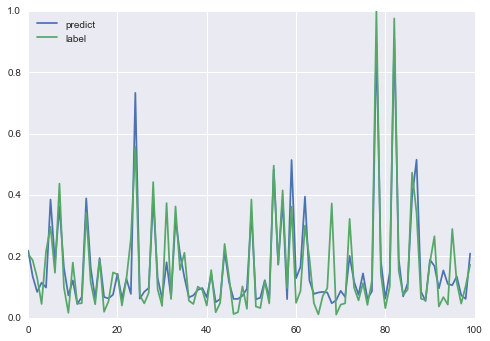

In [25]:
plt.plot(y_test_predict[:100] , label='predict')
plt.plot(y_test[:100] , label='label')
plt.legend(loc='upper left')



### Seperate model
general model + seperate model

In [26]:
main_input = Input(shape=(num_feature,), dtype='float32', name='main_input')
main_input_bn = keras.layers.normalization.BatchNormalization()(main_input)
main_input_noise = keras.layers.noise.GaussianNoise(0.01)(main_input_bn)
main_layer_0 = Dense(num_feature , activation='relu', name='main_layer0')(main_input_noise)
gate_layer_0 = Dense(num_feature , activation='sigmoid', name='gate_layer0')(main_input)
prod_layer_0 = keras.layers.merge([main_layer_0, gate_layer_0], mode='mul')
main_layer_1 = Dense(num_feature , activation='relu', name='main_layer1')(prod_layer_0)
gate_layer_1 = Dense(num_feature , activation='sigmoid', name='gate_layer1')(main_input)
prod_layer_1 = keras.layers.merge([main_layer_0, gate_layer_0], mode='mul')

main_layer_2 = Dense(num_feature, activation='relu', name='main_layer2')(prod_layer_1)


main_predict = Dense(1, activation=None, name='main_predict')(main_layer_2)
# main_model = Model(input=main_input, output=main_predict)
seperate_layer = [ Dense(num_feature, activation='relu', name='sep_layer{}'.format(i))(main_layer_2) for i in range(46)]
seperate_predict = [ Dense(1, activation=None, name='sep_predict{}'.format(i))(s) for i, s in enumerate(seperate_layer)]

attention_layer = [ Dense(num_feature, activation='relu', name='att_layer{}'.format(i))(main_input) for i in range(46)]
attention_predict = [ Dense(1, activation='sigmoid', name='att_predict{}'.format(i))(s) for i, s in enumerate(attention_layer)]
attention_predict_all = keras.layers.concatenate(attention_predict)
attention_score = Dense(46, activation='softmax', name = 'attention_socre')(attention_predict_all)

seperate_predict_merge = keras.layers.concatenate(seperate_predict)
full_scored_predict = keras.layers.merge([seperate_predict_merge, attention_score], mode='dot')
# full_predict_list = seperate_predict + [main_predict]
full_predict = keras.layers.merge([full_scored_predict, main_predict], mode='ave')
# full_predict = keras.layers.merge(full_predict_list,mode='ave')

seperate_model = Model(input=main_input, output=full_predict)



/Users/guoyinwang/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/guoyinwang/anaconda3/lib/python3.5/site-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/Users/guoyinwang/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/guoyinwang/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/guoyinwang/

In [ ]:
seperate_model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mape'])

In [ ]:
seperate_model.fit(x_train, y_train,nb_epoch=50,validation_data=[x_test,y_test])

/Users/guoyinwang/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 22576 samples, validate on 3985 samples
Epoch 1/50
22576/22576 [==============================] - 48s - loss: 0.0097 - mean_absolute_percentage_error: 176183.3403 - val_loss: 0.0088 - val_mean_absolute_percentage_error: 120352.2398
Epoch 2/50
22576/22576 [==============================] - 40s - loss: 0.0076 - mean_absolute_percentage_error: 185497.9867 - val_loss: 0.0087 - val_mean_absolute_percentage_error: 122566.6105
Epoch 3/50
22576/22576 [==============================] - 40s - loss: 0.0075 - mean_absolute_percentage_error: 183375.4355 - val_loss: 0.0081 - val_mean_absolute_percentage_error: 124219.9467
Epoch 4/50
22576/22576 [==============================] - 40s - loss: 0.0072 - mean_absolute_percentage_error: 173911.5463 - val_loss: 0.0072 - val_mean_absolute_percentage_error: 119562.1683
Epoch 5/50
22576/22576 [==============================] - 43s - loss: 0.0070 - mean_absolute_percentage_error: 169135.9009 - val_loss: 0.0067 - val_mean_absolute_percentage_error: 116

In [ ]:
y_test_predict = seperate_model.predict(x_test)

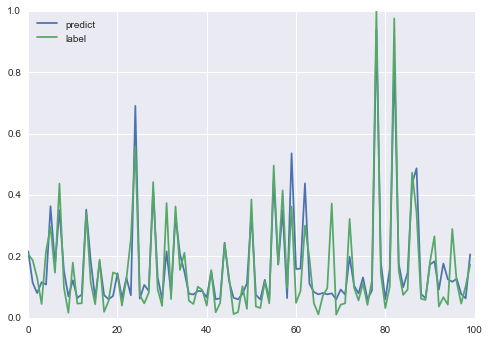

In [ ]:
plt.plot(y_test_predict[:100] , label='predict')
plt.plot(y_test[:100] , label='label')
plt.legend(loc='upper left')




## Section 3: Prediction

In [ ]:
holiday = ['2016-02-7',
          '2016-02-8',
           '2016-02-9',
           '2016-02-10',
           '2016-02-11',
           '2016-02-12',
           '2016-02-13',
           '2016-04-04',
           '2016-05-02',
           '2016-05-01',
           '2016-06-9',
           '2016-06-10',
           '2016-06-11',
           '2016-09-15',
           '2016-09-16',
           '2016-09-17',
           '2016-10-01',
           '2016-10-02',
           '2016-10-03',
           '2016-10-04',
           '2016-10-05',
           '2016-10-06',
           '2016-10-07',
          ]
# window = 5
import glob
path =r'data 2' # use your path
allFiles = glob.glob(path + "/*.csv")

list_test_ = []
for j, file_ in enumerate(allFiles):
    ratio = pd.DataFrame()
    df = pd.read_csv(file_,index_col=None, header=None, names = ['year', 'month','day', 'high', 'low', 'ave', 'hum', 'ele'])
    ratio['ave'] = df['ave'] 
    ratio['high'] = df['high'] 
    ratio['low'] = df['low'] 
    ratio['hum'] = df['hum'] 
    # high order term
    ratio['ave2'] = ratio['ave'] ** 2
    ratio['ave3'] = ratio['ave'] ** 3
    
    # categorical transform
    ratio['ave_int'] = np.floor(ratio['ave']).astype('int')
    ratio['ave2_int'] = np.floor(ratio['ave2']).astype('int')
    ratio['ave3_int'] = np.floor(ratio['ave3']).astype('int')
    
    # interaction
    ratio['ave_hum'] = ratio['ave'] * ratio['hum']
    #scale
#     scaler_ele = MinMaxScaler(feature_range=(0, 1))
#     ratio['ele_scale'] = scaler_ele.fit_transform(ratio['ele'])
#     scaler_list.append(scaler_ele)
    
#     # prev
#     ratio['ele_prev'] = ratio['ele'].shift(1)
#     ratio.loc[0,'ele_prev'] = ratio['ele'][0]
    
#     ratio['hum_prev'] = ratio['hum'].shift(1)
#     ratio.loc[0,'hum_prev'] = ratio['hum'][0]
    
#     ratio['ave_prev'] = ratio['ave'].shift(1)
#     ratio.loc[0,'ave_prev'] = ratio['ave'][0]
    
#     ratio['ave2_prev'] = ratio['ave2'].shift(1)
#     ratio.loc[0,'ave2_prev'] = ratio['ave2'][0]
    
#     ratio['ave3_prev'] = ratio['ave3'].shift(1)
#     ratio.loc[0,'ave3_prev'] = ratio['ave3'][0]
    
#     ratio['ave_hum_prev'] = ratio['ave_hum'].shift(1)
#     ratio.loc[0,'ave_hum_prev'] = ratio['ave_hum'][0]
    
#     # multi prev 
#     ratio['ele_roll'] = pd.rolling_mean(ratio['ele'], window)
#     for i in range(window):
#         ratio.loc[i,'ele_roll'] = ratio['ele_prev'][i]
        
#     ratio['ave_roll'] = pd.rolling_mean(ratio['ave'], window)
#     for i in range(window):
#         ratio.loc[i,'ave_roll'] = ratio['ave_prev'][i]
    
#     ratio['ave2_roll'] = pd.rolling_mean(ratio['ave2'], window)
#     for i in range(window):
#         ratio.loc[i,'ave2_roll'] = ratio['ave2_prev'][i]
    
#     ratio['ave3_roll'] = pd.rolling_mean(ratio['ave3'], window)
#     for i in range(window):
#         ratio.loc[i,'ave3_roll'] = ratio['ave3_prev'][i]
    
#     ratio['hum_roll'] = pd.rolling_mean(ratio['hum'], window)
#     for i in range(window):
#         ratio.loc[i,'hum_roll'] = ratio['hum_prev'][i]
        
#     ratio['ave_hum_roll'] = pd.rolling_mean(ratio['ave_hum'], window)
#     for i in range(window):
#         ratio.loc[i,'ave_hum_roll'] = ratio['ave_hum_prev'][i]
    
    
    # date
    ratio['date']= pd.to_datetime(df[['year','month','day']], yearfirst=True)
    ratio['weekend'] = (ratio['date'].dt.dayofweek // 5 == 1).astype(float)
    ratio['holiday'] =  ratio['date'].isin(holiday).astype(float)
    ratio['non_workday'] = ratio[['weekend' ,'holiday']].max(axis=1)
    ratio['workday'] = 1 - ratio['non_workday']
    ratio.replace([np.inf, -np.inf], np.nan, inplace=True)
    ratio = ratio.fillna(0.0)
    ratio.drop(['date'], axis=1, inplace=True)
#     ratio.drop(['weekend', 'holiday'], axis=1, inplace=True)
    ratio['group'] = j
    
    x_pred = ratio[feature_list].as_matrix()
    x_onehot = one_hot(x_pred[:,0].astype('int'))
#     print(x_pred[:,0].min(), x_pred[:,0].max())
    left = np.zeros([ x_pred.shape[0],x_pred[:,0].min().astype('int')-train_full['ave_int'].min().astype('int')])
    right = np.zeros([ x_pred.shape[0],-x_pred[:,0].max().astype('int') + train_full['ave_int'].max().astype('int')])
    x_pred = np.concatenate([x_onehot,right, x_pred[:,1:]], axis=1)
    df['ele'] = scaler_list[j].inverse_transform(seperate_model.predict(x_pred))
    
    df[['year', 'month','day', 'high', 'low', 'ave', 'hum','ele']].to_csv(file_, mode='w',header=False)

        
    list_test_.append(df)

In [ ]:
plt.plot(list)

NameError: name 'li' is not defined